<a href="https://colab.research.google.com/github/joaowinderfeldbussolotto/assistente-ppc-ciencia-da-computacao/blob/main/tcc_evaluation_analysis_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!mkdir -p data
!cp -r /content/drive/My\ Drive/tcc/resultados/validados/deepeval/* data/


In [11]:
import os
import glob

def get_latest_file(directory, pattern):
    file_list = glob.glob(os.path.join(directory, pattern))

    if not file_list:
        raise FileNotFoundError("No files found matching the pattern.")

    latest_file = max(file_list, key=os.path.getmtime)

    return latest_file


In [19]:
base_directory = 'data/mistral-large-latest_/'
pattern = '*NAIVE*'


naive_latest_file = get_latest_file(base_directory, pattern)
advanced_latest_file = get_latest_file(base_directory, '*ADVANCED*')

In [20]:
advanced_latest_file

'data/mistral-large-latest_/mistral-large-latest_fd4aeb_ADVANCED_19_10_2024_23-29-34.json'

In [21]:
import pandas as pd

naive_df = pd.read_json(naive_latest_file)
advanced_df = pd.read_json(advanced_latest_file)

In [29]:
def filter_metrics(row):
    return [metric for metric in row if metric.get("score") != -1]

# Apply the function to the 'metrics' column
advanced_df["metrics"] = advanced_df["metrics"].apply(filter_metrics)

In [30]:
evaluation_results = {'NAIVE': naive_df,
                      'ADVANCED': advanced_df}

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def extract_metrics(dataframe):
    metrics = []
    for _, row in dataframe.iterrows():
        for metric in row['metrics']:
            metrics.append({
                'metric_name': metric['name'],
                'score': metric['score'],
                'success': metric['success']
            })
    return pd.DataFrame(metrics)

def clean_technique_name(name):
    return name.rstrip('_')

def ensure_axes_are_list(axes):
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    return axes

# Gráfico de sucessos e falhas por técnica RAG
def plot_success_failure(rag_techniques):
    fig, axes = plt.subplots(1, len(rag_techniques), figsize=(20, 5), constrained_layout=True)
    axes = ensure_axes_are_list(axes)

    for idx, (technique_name, df) in enumerate(rag_techniques.items()):
        clean_name = clean_technique_name(technique_name)
        df_metrics = extract_metrics(df)

        success_counts = df_metrics.groupby('metric_name')['success'].value_counts().unstack(fill_value=0)
        totals = success_counts.sum(axis=1)

        success_counts.plot(kind='barh', stacked=True, ax=axes[idx], color=['lightcoral', 'lightgreen'])
        axes[idx].set_xlabel('Count')
        axes[idx].set_ylabel('Metric')
        axes[idx].set_title(f'Success/Failure ({clean_name})')

        for i, (metric, success) in enumerate(success_counts.iterrows()):
            total = totals[i]
            axes[idx].text(success[True] - 3, i, f'{int(success[True])} ({(success[True] / total) * 100:.1f}%)', va='center')

    plt.show()

# Gráfico de médias por técnica RAG
def plot_average_scores(rag_techniques):
    fig, axes = plt.subplots(1, len(rag_techniques), figsize=(20, 5), constrained_layout=True)
    axes = ensure_axes_are_list(axes)

    for idx, (technique_name, df) in enumerate(rag_techniques.items()):
        clean_name = clean_technique_name(technique_name)
        df_metrics = extract_metrics(df)

        avg_scores = df_metrics.groupby('metric_name')['score'].mean()

        bars = axes[idx].barh(avg_scores.index, avg_scores.values, color='lightblue')
        axes[idx].set_xlabel('Average Score')
        axes[idx].set_ylabel('Metric')
        axes[idx].set_title(f'Average Score ({clean_name})')

        for bar in bars:
            width = bar.get_width()
            axes[idx].text(width - 0.1, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

    plt.show()

# Gráfico de distribuição de pontuações por técnica RAG
def plot_score_distribution(rag_techniques):
    fig, axes = plt.subplots(1, len(rag_techniques), figsize=(20, 5), constrained_layout=True)
    axes = ensure_axes_are_list(axes)

    for idx, (technique_name, df) in enumerate(rag_techniques.items()):
        clean_name = clean_technique_name(technique_name)
        df_metrics = extract_metrics(df)

        df_metrics['score'].plot(kind='hist', bins=10, ax=axes[idx], color='lightgreen', edgecolor='black')
        axes[idx].set_xlabel('Score')
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'Score Distribution ({clean_name})')

    plt.show()


<ipython-input-23-2e5f15dbb080>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total = totals[i]
<ipython-input-23-2e5f15dbb080>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total = totals[i]


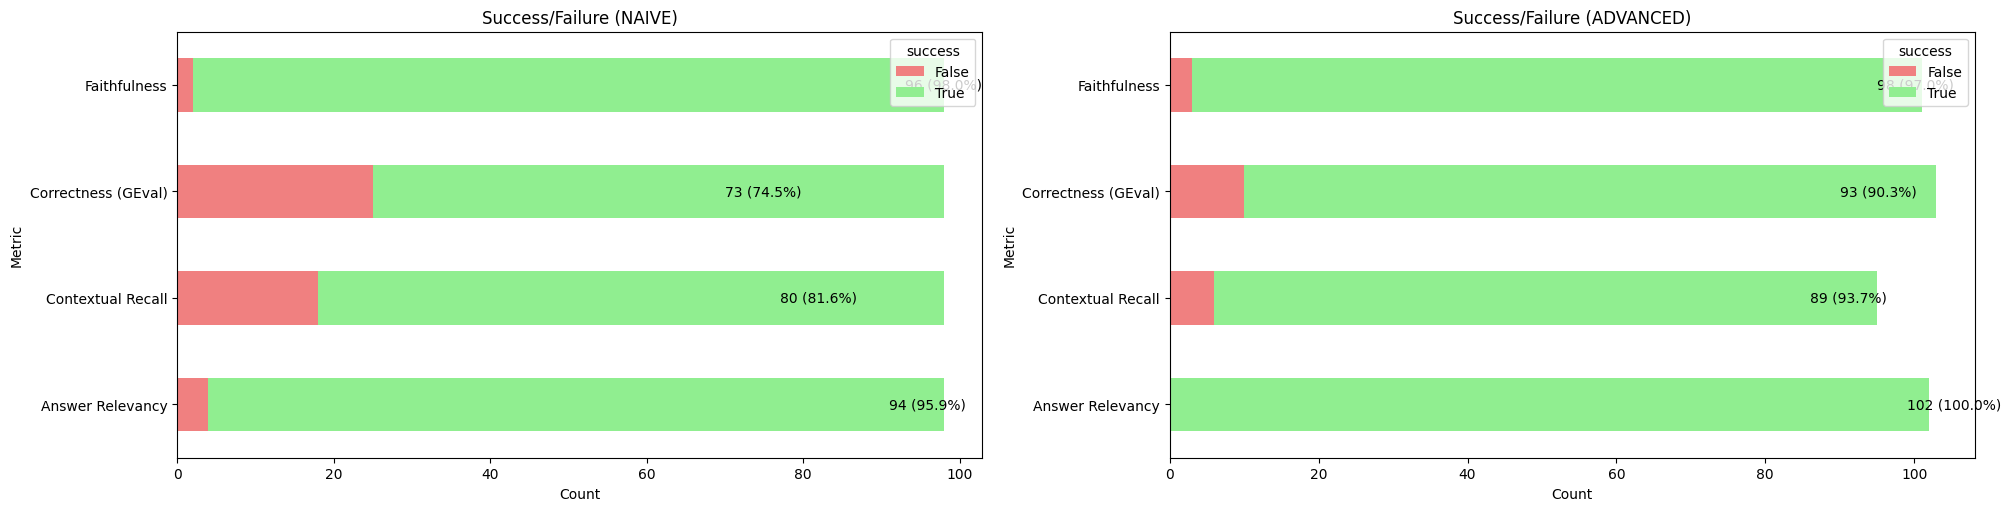

In [31]:
plot_success_failure(evaluation_results)


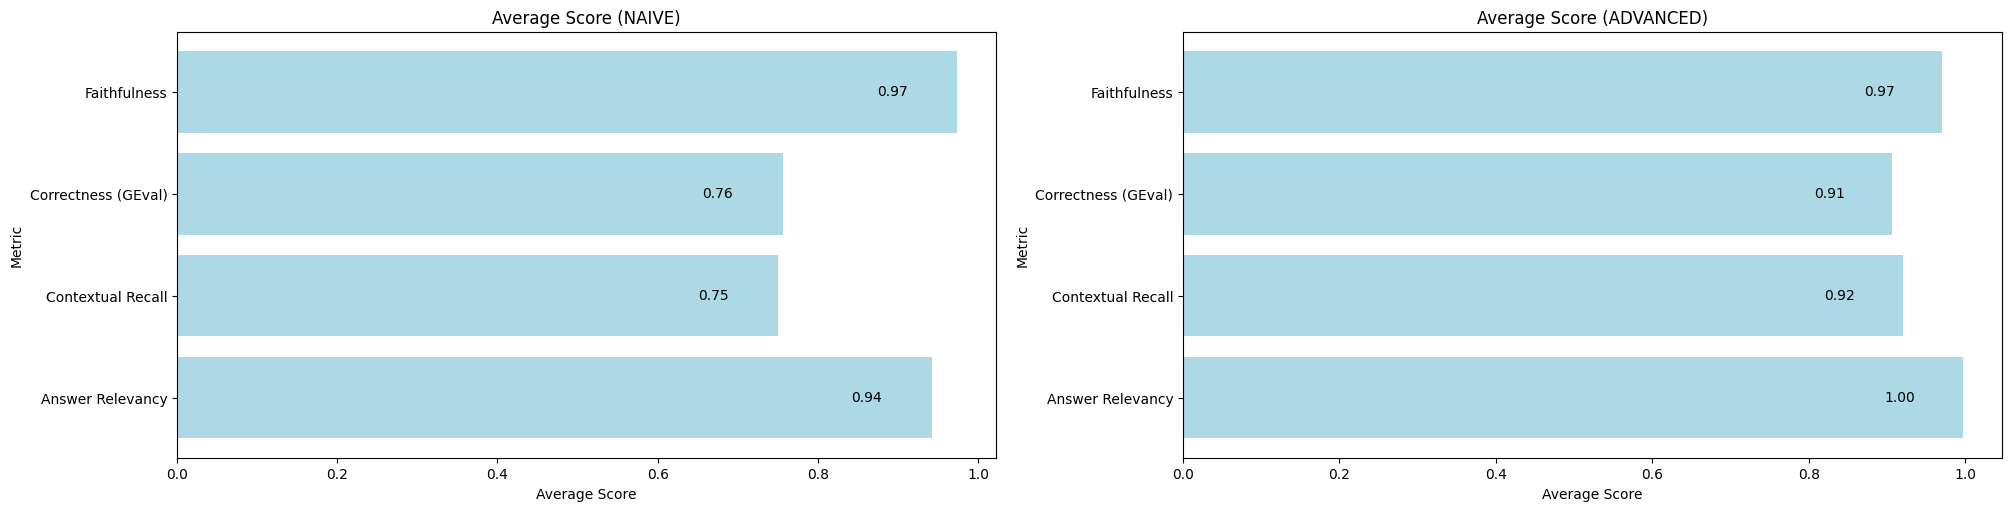

In [32]:
plot_average_scores(evaluation_results)


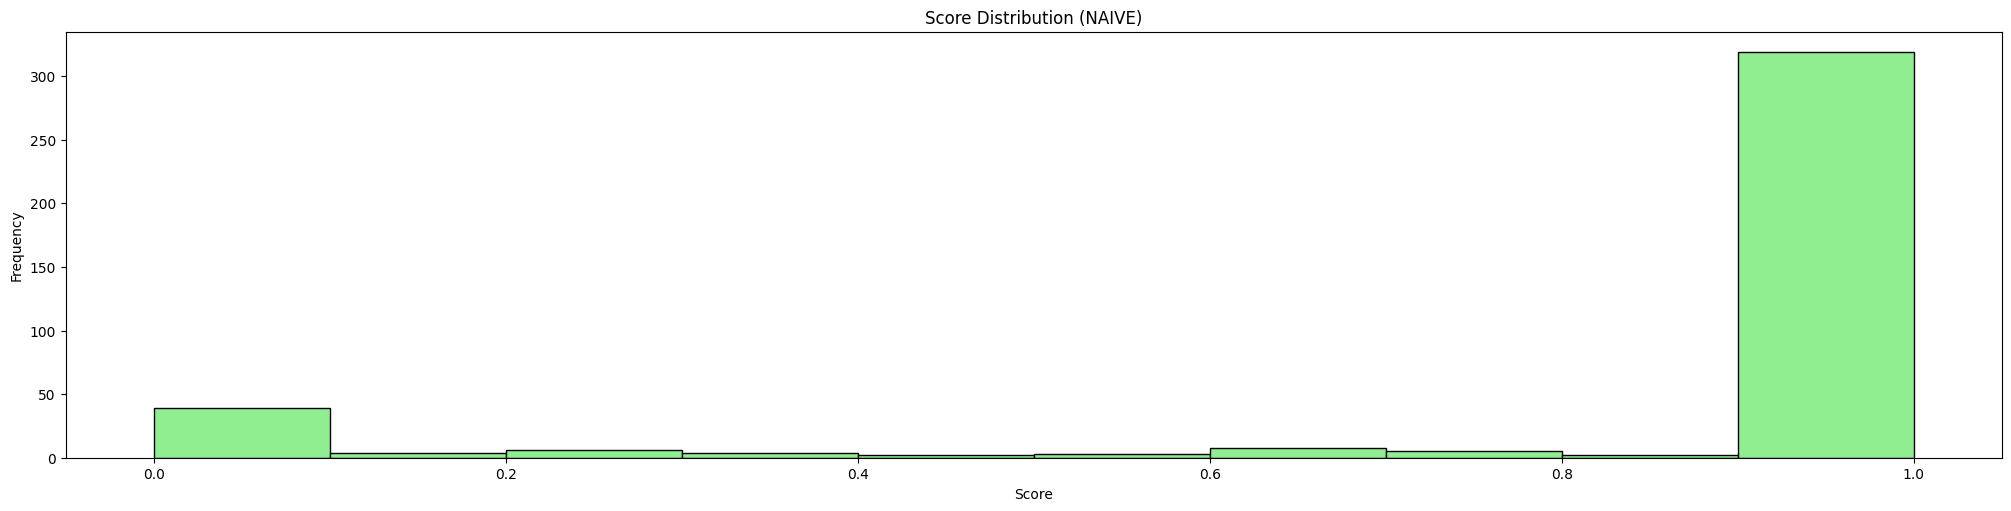

In [30]:
plot_score_distribution(evaluation_results)

In [51]:
import matplotlib.pyplot as plt
import pandas as pd


# Função para extrair as métricas do dataframe, adicionando o nome da técnica RAG
def extract_metrics(dataframe, technique_name):
    metrics = []
    for _, row in dataframe.iterrows():
        for metric in row['metrics']:
            metrics.append({
                'metric_name': metric['name'],
                'score': metric['score'],
                'technique': technique_name  # Adiciona o nome da técnica RAG
            })
    return pd.DataFrame(metrics)

# Função para limpar o nome da técnica RAG (caso necessário)
def clean_technique_name(name):
    return name.rstrip('_')

# Função para gerar gráfico de comparação de métricas entre as técnicas de RAG
def plot_metric_comparison(rag_techniques):
    # Lista para armazenar as métricas de cada técnica
    all_metrics = []

    # Extrair as métricas de cada técnica RAG
    for technique_name, df in rag_techniques.items():
        df_metrics = extract_metrics(df, clean_technique_name(technique_name))
        all_metrics.append(df_metrics)

    # Concatenar os dados de todas as técnicas
    combined_metrics_df = pd.concat(all_metrics)

    # Pivotar os dados para preparar para o gráfico
    pivot_df = combined_metrics_df.pivot_table(values='score', index='metric_name', columns='technique')

    # Plotando o gráfico de barras agrupadas
    pivot_df.plot(kind='bar', figsize=(10, 6), color=['#FF8C00', '#FF4500'])  # Cores personalizadas para cada técnica
    plt.title('Comparação de Métricas entre Técnicas RAG')
    plt.xlabel('Métrica')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(title='Técnicas RAG')
    plt.tight_layout()

    plt.show()




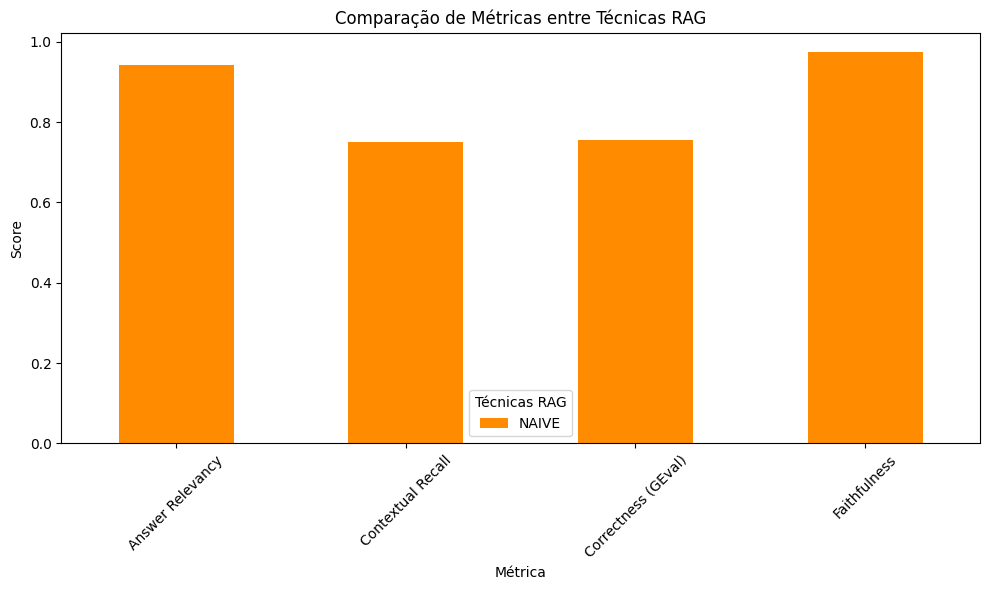

In [52]:
# Chamando a função para gerar o gráfico de comparação
plot_metric_comparison(evaluation_results)

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Função para limpar o nome da técnica RAG (caso necessário)
def clean_technique_name(name):
    return name.rstrip('_')

# Função para gerar gráfico de sucessos com barras verticais e labels
def plot_success_comparison_with_title(rag_techniques):
    success_data = []

    # Contar o número de sucessos para cada técnica RAG
    for technique_name, df in rag_techniques.items():
        true_count = df['success'].value_counts().get(True, 0)  # Contar casos de sucesso (True)
        total_count = len(df)  # Total de inputs avaliados
        percentage = (true_count / total_count) * 100  # Calcular porcentagem de sucessos
        success_data.append({
            'technique': clean_technique_name(technique_name),
            'success_count': true_count,
            'percentage': percentage
        })

    # Converter em DataFrame
    success_df = pd.DataFrame(success_data)

    # Plotar o gráfico de barras verticais
    ax = success_df.plot(kind='bar', x='technique', y='success_count', color='#4E79A7', legend=False, figsize=(8, 5))
    plt.title('Distribuição de Casos de Testes Aprovados por Técnica RAG')
    plt.xlabel('Técnica RAG')
    plt.ylabel('Número de Sucessos')

    # Adicionar labels e porcentagem nas barras
    for index, row in success_df.iterrows():
        ax.text(index, row['success_count'] + 0.5, f"{row['success_count']} ({row['percentage']:.1f}%)", ha='center')

    plt.tight_layout()
    plt.show()


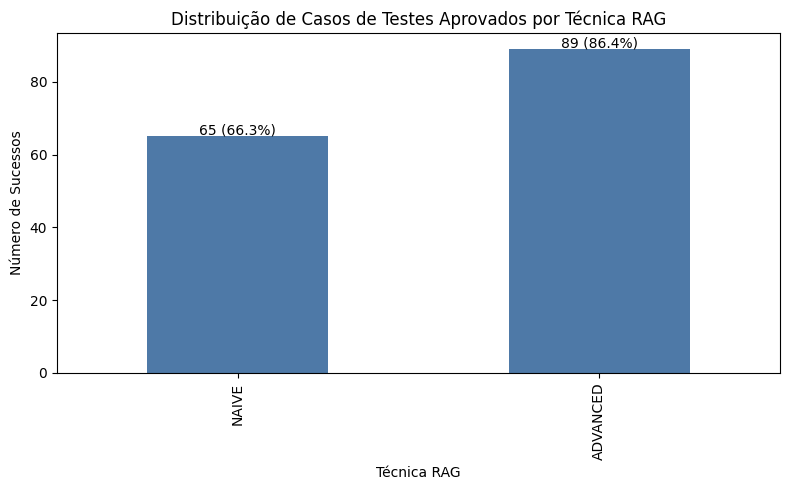

In [34]:
plot_success_comparison_with_title(evaluation_results)

In [37]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [71]:
naive_df.iloc[0].additional_metadata

{'PromptTokens': 2351,
 'CompletionTokens': 62,
 'TotalTokens': 2413,
 'ConfiguracaoDeInferencia': 'NAIVE: open-mixtral-8x22b Contexto: 5. PINECONE normal',
 'Documento': 'ppc2018'}

In [70]:
import pandas as pd

# Função para unificar inputs falhos e agregar métricas com informações de PPC a partir de 'additional_metadata'
def combine_failed_inputs_with_ppc_and_aggregated_metrics(rag_techniques):
    combined_failures_list = []

    # Extrair inputs com falha de cada técnica RAG
    for technique_name, df in rag_techniques.items():
        for _, row in df.iterrows():
            # Coletar as métricas que falharam (success == False)
            failed_metrics = [metric['name'] for metric in row['metrics'] if not metric['success']]

            # Extrair o PPC a partir de 'additional_metadata'
            ppc_value = row['additional_metadata'].get('Documento')

            # Se houver falhas, adicionar à lista
            if failed_metrics:
                combined_failures_list.append({
                    'input': row['input'],
                    'actual_output': row['actual_output'],
                    'expected_output': row['expected_output'],
                    'failed_metrics': ', '.join(failed_metrics),  # Junta todas as métricas que falharam
                    'technique': clean_technique_name(technique_name),
                    'PPC': ppc_value  # Manter a coluna PPC a partir de 'additional_metadata'
                })

    combined_failures_df = pd.DataFrame(combined_failures_list)

    # Agrupar por `input`, `actual_output`, `expected_output`, e `PPC`, agregando as métricas e técnicas
    combined_failures_aggregated = combined_failures_df.groupby(['input', 'actual_output', 'expected_output', 'PPC']) \
                                         .agg({
                                             'failed_metrics': lambda x: ', '.join(x.unique()),  # Agregar as métricas falhadas
                                             'technique': lambda x: ', '.join(x.unique())  # Agregar as técnicas que falharam
                                         }).reset_index()

    combined_failures_aggregated['Numero de Técnicas que Falharam'] = combined_failures_aggregated['technique'].apply(lambda x: len(x.split(', ')))

    combined_failures_aggregated = combined_failures_aggregated.rename(columns={'technique': 'Técnicas Avaliaram Como Errado'})

    combined_failures_aggregated = combined_failures_aggregated[['input', 'PPC', 'Técnicas Avaliaram Como Errado', 'actual_output', 'expected_output', 'failed_metrics', 'Numero de Técnicas que Falharam']]
    combined_failures_aggregated = combined_failures_aggregated.sort_values(by='Numero de Técnicas que Falharam', ascending=False)

    return combined_failures_aggregated




In [69]:
failed_inputs_combined_with_ppc = combine_failed_inputs_with_ppc_and_aggregated_metrics(evaluation_results)
failed_inputs_combined_with_ppc.head()

,input,PPC,Técnicas Avaliaram Como Errado,actual_output,expected_output,failed_metrics,Numero de Técnicas que Falharam
0,Como o TCC I é avaliado?,ppc2018,NAIVE,"A resposta para a pergunta ""Como o TCC I é avaliado?"" não foi encontrada nos trechos fornecidos do PPC. Os trechos mencionam a avaliação do TCC II, mas não fornecem informações específicas sobre a avaliação do TCC I. O Artigo 18 menciona que os critérios e as formas de avaliação do estudante nos componentes curriculares TCC I e TCC II serão propostos por uma comissão designada pelo coordenador do curso e para homologação do Colegiado de Curso, mas não fornece detalhes sobre como essa avaliação será realizada.","Art. 24º A avaliação do estudante será realizada pela banca avaliadora.\nArt. 25º Os critérios e as formas de avaliação do estudante, nos componentes curriculares\nTCC I e TCC II, serão propostos pelos professores orientadores e homologados pelo Colegiado de Curso.\nParágrafo único: após a homologação, os critérios e as formas de avaliação constarão nos\nrespectivos planos de ensino dos componentes curriculares TCC I e II.","Correctness (GEval), Answer Relevancy",1
17,Qual é a ementa de Cálculo II?,ppc2024,NAIVE,"A ementa de Cálculo II não está disponível nos trechos fornecidos do PPC. Portanto, não é possível fornecer uma resposta precisa e confiável com base nas informações disponíveis.",Algumas técnicas de integração e aplicações da integral. Funções de várias variáveis. Limite e continuidade de funções de várias variáveis. Derivadas parciais e aplicações. Gradiente. Diferenciabilidade. Multiplicadores de Lagrange. Integrais múltiplas.,"Correctness (GEval), Contextual Recall",1
31,Qual é a ementa de Trabalho de Conclusão de Curso II?,ppc2024,NAIVE,"A ementa de Trabalho de Conclusão de Curso II não está explicitamente descrita nos trechos fornecidos do PPC. Portanto, não é possível fornecer uma resposta precisa com base apenas nas informações disponíveis.","Desenvolvimento das atividades previstas no projeto elaborado em TCC I e produção do texto final do TCC, seguida de defesa perante a banca.",Correctness (GEval),1
30,Qual é a ementa de Programação II?,ppc2018,NAIVE,A pergunta não foi encontrada no trecho fornecido do PPC. A ementa de Programação II não foi mencionada nos trechos fornecidos.,"Conceitos de aplicações para a Web. Conceitos básicos sobre estrutura cliente/servidor, arquitetura em camadas. Servidores web. Mecanismos de renderização de conteúdo. Linguagens de marcação. Folhas de CSS. Linguagens client-side e server-side. Protocolo HTTP/HTTPS e troca de informações entre clientes e servidores. Cookies, sessões e autenticação. Integração de aplicações web com banco de dados. Padrão MVC e frameworks de desenvolvimento.","Correctness (GEval), Answer Relevancy, Contextual Recall",1
29,Qual é a ementa de Pesquisa e Ordenação de Dados?,ppc2018,NAIVE,"A ementa de Pesquisa e Ordenação de Dados não está explicitamente descrita nos trechos fornecidos do Plano Pedagógico do Curso (PPC) de Ciência da Computação da UFFS. Portanto, não é possível fornecer uma resposta precisa e confiável com base apenas nas informações disponíveis.",Métodos de ordenação. Busca linear e binária. Organização de arquivos. Persistência de dados. Ordenação externa. Índices (árvores B+ e hashing). Compactação de dados. Implementações com linguagem imperativa estruturada.,Correctness (GEval),1


In [62]:
# Contar o número de falhas por PPC
falhas_por_ppc = failed_inputs_combined_with_ppc['PPC'].value_counts()

# Exibir os resultados
print(falhas_por_ppc)



PPC
ppc2018    17
ppc2024    16
Name: count, dtype: int64


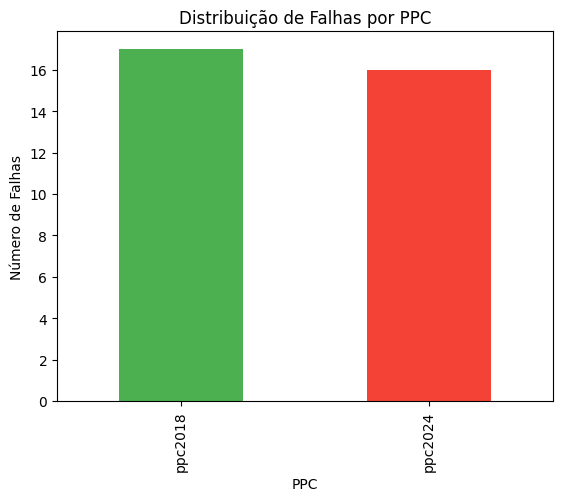

In [63]:
import matplotlib.pyplot as plt

# Contar o número de falhas por PPC
falhas_por_ppc = failed_inputs_combined_with_ppc['PPC'].value_counts()

# Gráfico de barras para comparar falhas entre PPC 2018 e PPC 2024
falhas_por_ppc.plot(kind='bar', color=['#4CAF50', '#F44336'])
plt.title('Distribuição de Falhas por PPC')
plt.xlabel('PPC')
plt.ylabel('Número de Falhas')
plt.show()


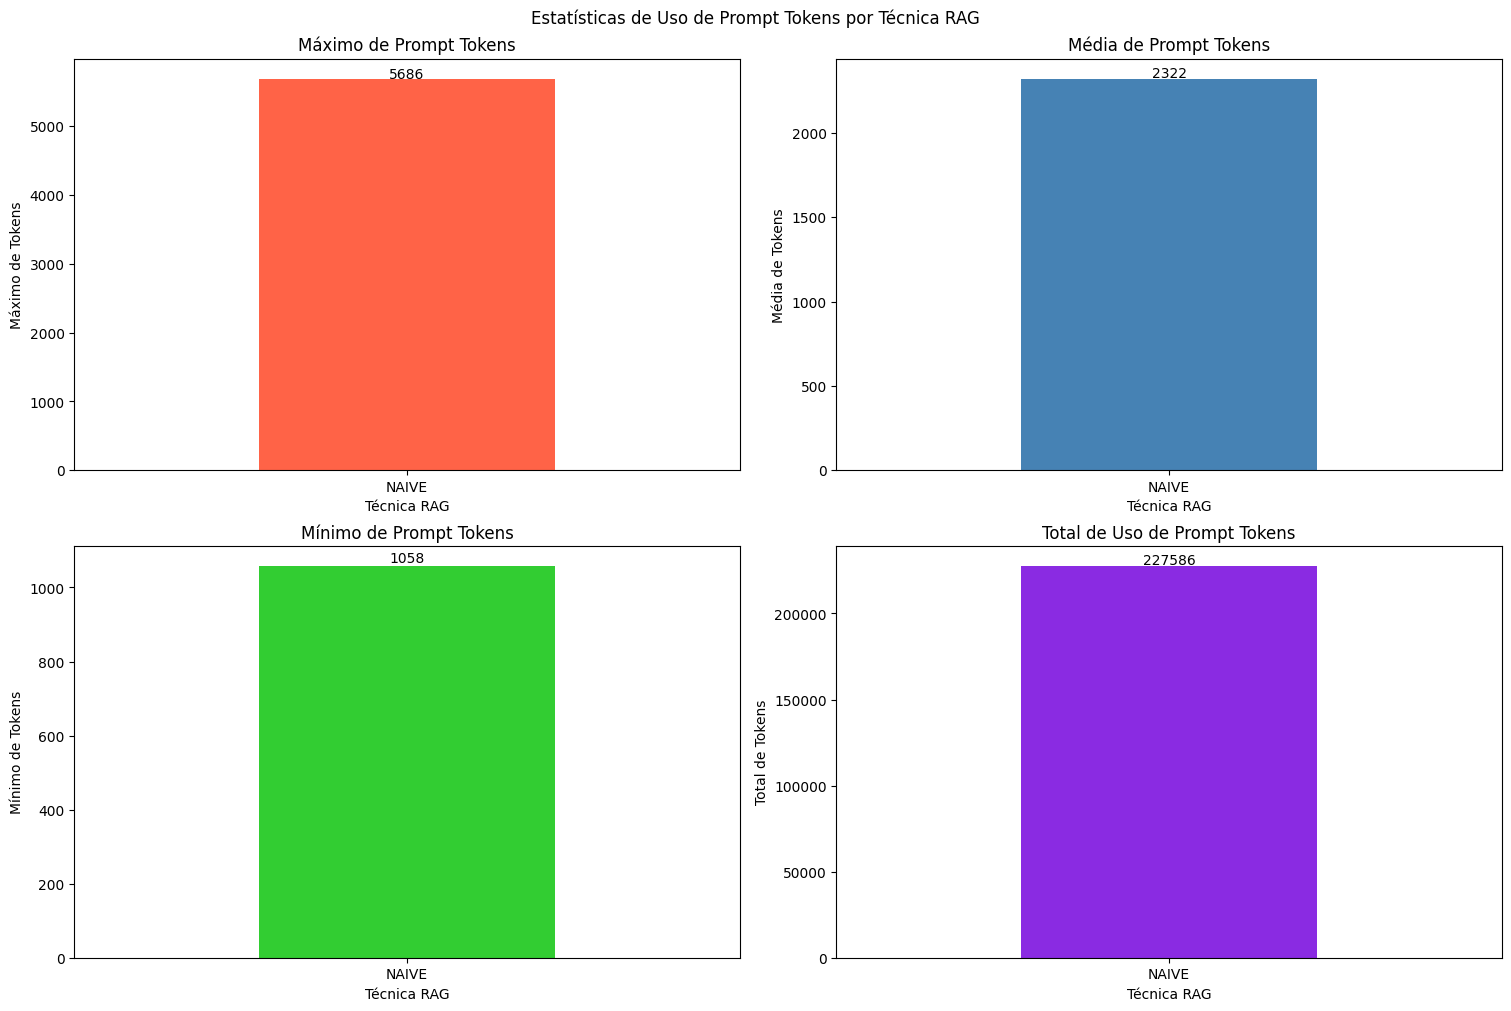

In [78]:
import matplotlib.pyplot as plt
import pandas as pd

# Função para extrair dados de uso de tokens, focando em PromptTokens
def extract_prompt_tokens(dataframe, technique_name):
    token_data = []
    for _, row in dataframe.iterrows():
        metadata = row['additional_metadata']
        token_data.append({
            'technique': technique_name,
            'prompt_tokens': metadata.get('PromptTokens', 0)
        })
    return pd.DataFrame(token_data)

# Função para gerar um "dashboard" de estatísticas de PromptTokens
def plot_prompt_token_dashboard(rag_techniques):
    all_token_data = []

    # Extrair dados de tokens para cada técnica
    for technique_name, df in rag_techniques.items():
        technique_clean = clean_technique_name(technique_name)
        token_data = extract_prompt_tokens(df, technique_clean)
        all_token_data.append(token_data)

    # Concatenar os dados
    combined_token_df = pd.concat(all_token_data)

    # Calcular estatísticas por técnica
    token_stats = combined_token_df.groupby('technique')['prompt_tokens'].agg(['min', 'mean', 'max', 'sum'])

    # Criar um único painel para visualização
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)

    # Gráfico 1: Máximo de Prompt Tokens
    ax1 = axes[0, 0]
    token_stats['max'].plot(kind='bar', color='#FF6347', ax=ax1, width=0.4)
    ax1.set_title('Máximo de Prompt Tokens')
    ax1.set_xlabel('Técnica RAG')
    ax1.set_ylabel('Máximo de Tokens')
    ax1.tick_params(axis='x', rotation=0)
    for index, value in enumerate(token_stats['max']):
        ax1.text(index, value + 10, f"{value:.0f}", ha='center')

    # Gráfico 2: Média de Prompt Tokens
    ax2 = axes[0, 1]
    token_stats['mean'].plot(kind='bar', color='#4682B4', ax=ax2, width=0.4)
    ax2.set_title('Média de Prompt Tokens')
    ax2.set_xlabel('Técnica RAG')
    ax2.set_ylabel('Média de Tokens')
    ax2.tick_params(axis='x', rotation=0)
    for index, value in enumerate(token_stats['mean']):
        ax2.text(index, value + 10, f"{value:.0f}", ha='center')

    # Gráfico 3: Mínimo de Prompt Tokens
    ax3 = axes[1, 0]
    token_stats['min'].plot(kind='bar', color='#32CD32', ax=ax3, width=0.4)
    ax3.set_title('Mínimo de Prompt Tokens')
    ax3.set_xlabel('Técnica RAG')
    ax3.set_ylabel('Mínimo de Tokens')
    ax3.tick_params(axis='x', rotation=0)
    for index, value in enumerate(token_stats['min']):
        ax3.text(index, value + 10, f"{value:.0f}", ha='center')

    # Gráfico 4: Total de Prompt Tokens
    ax4 = axes[1, 1]
    token_stats['sum'].plot(kind='bar', color='#8A2BE2', ax=ax4, width=0.4)
    ax4.set_title('Total de Uso de Prompt Tokens')
    ax4.set_xlabel('Técnica RAG')
    ax4.set_ylabel('Total de Tokens')
    ax4.tick_params(axis='x', rotation=0)
    for index, value in enumerate(token_stats['sum']):
        ax4.text(index, value + 1000, f"{value:.0f}", ha='center')

    plt.suptitle('Estatísticas de Uso de Prompt Tokens por Técnica RAG')
    plt.show()

# Como usar:
rag_techniques = {
    'NAIVE': naive_df}

# Gerar o "dashboard" com as estatísticas de PromptTokens
plot_prompt_token_dashboard(rag_techniques)
